In [45]:
import pandas as pd
import numpy as np
from taigapy import create_taiga_client_v3
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt


# Import and prepare data

In [46]:
# read in dependency matrix of interest
e3_tf_corr = pd.read_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr_significant.pkl")

In [47]:
e3_tf_corr.head()

,lineage,TF,E3_ligase,p-val,corr,TF-class,fdr,log10q,name
14339,Biliary Tract,DMRT1,PDZRN3,5.360362e-06,0.678751,Positive,0.046343,1.334020,DMRT1-PDZRN3
14362,Biliary Tract,POU3F4,PDZRN3,7.373695e-08,0.760493,Positive,0.001039,2.983481,POU3F4-PDZRN3
14369,Biliary Tract,TP53,PDZRN3,3.209376e-08,0.773384,Positive,0.000603,3.219807,TP53-PDZRN3
27405,Biliary Tract,ZNF221,TRIM26,1.404946e-05,-0.655954,Positive,0.098961,1.004536,ZNF221-TRIM26
46539,Biliary Tract,DMRT1,KLHL10,6.492342e-07,0.722565,Positive,0.007317,2.135675,DMRT1-KLHL10


In [48]:
e3_tf_corr_filtered =  e3_tf_corr[e3_tf_corr["lineage"] == "Lymphoid"]

In [49]:
e3_tf_corr_filtered.head()

,lineage,TF,E3_ligase,p-val,corr,TF-class,fdr,log10q,name
641641,Lymphoid,ISX,RNF145,2.073245e-05,0.421769,Positive,0.026014,1.584791,ISX-RNF145
641756,Lymphoid,EBF1,RNF157,2.642728e-07,0.499027,Negative,0.001265,2.897891,EBF1-RNF157
641776,Lymphoid,IRF4,RNF157,1.093921e-04,-0.386502,Negative,0.079553,1.099341,IRF4-RNF157
642264,Lymphoid,EBF1,SH3RF2,5.686061e-06,0.446710,Negative,0.011414,1.942550,EBF1-SH3RF2
642292,Lymphoid,POU2AF1,SH3RF2,1.021386e-04,0.388038,Negative,0.076579,1.115888,POU2AF1-SH3RF2


In [50]:
e3_tf_corr_filtered.to_csv("lymphoid_net.csv", index=False)

In [51]:
e3_ligases = e3_tf_corr_filtered[['E3_ligase']].drop_duplicates()

In [52]:
e3_ligases["TF-class"] = "E3 ligase"

In [53]:
e3_ligases.rename(columns={"E3_ligase": "TF"}, inplace=True)

In [54]:
pd.concat([e3_ligases, 
           e3_tf_corr_filtered[["TF", "TF-class"]].drop_duplicates()]).to_csv("lymphoid_nodes.csv", index = False)


# Make network plots

In [55]:
G=nx.from_pandas_edgelist(e3_tf_corr_filtered, 'TF', 'E3_ligase')

# Get TFs and E3_ligases from the DataFrame
TFs = e3_tf_corr_filtered['TF'].unique()
E3_ligases = e3_tf_corr_filtered['E3_ligase'].unique()
ts_like = [tf for tf in e3_tf_corr.loc[e3_tf_corr["TF-class"] == "Positive", "TF"]]
# set node colors
all_nodes = list(G.nodes())
node_groups = {node: 'TS-like' if node in ts_like else ('Onco-like' if node in TFs
                                                   else "E3") for node in all_nodes}

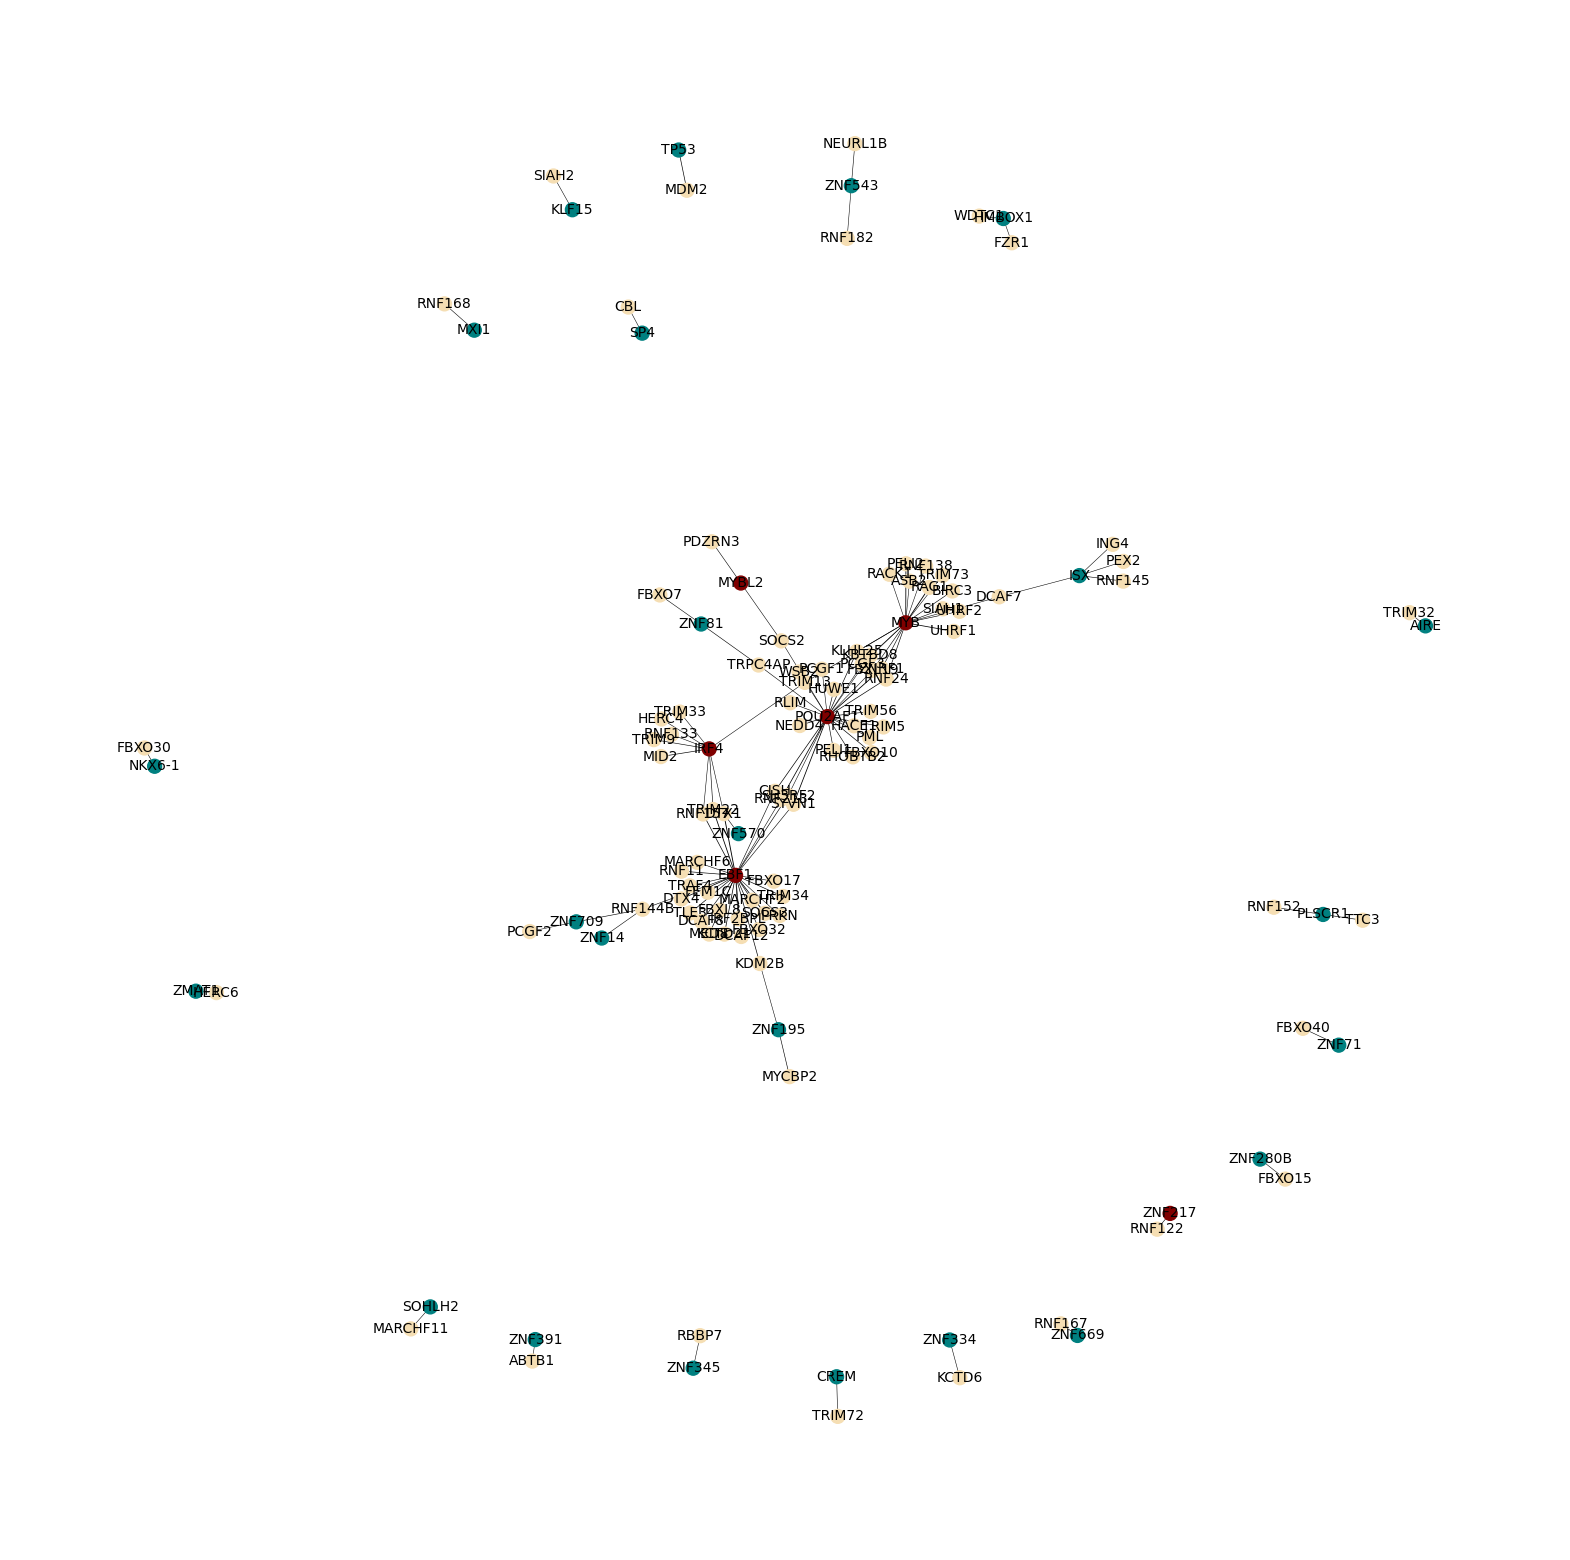

In [56]:
nx.set_node_attributes(G, node_groups, name='group')
color_map = {'TS-like': 'teal', 'Onco-like': 'maroon', "E3": "wheat"}
node_colors = [color_map[G.nodes[node]['group']] for node in G.nodes()]
 
# set edge thickness
edge_corr_values = e3_tf_corr_filtered.set_index(['TF', 'E3_ligase'])['corr'].to_dict()
nx.set_edge_attributes(G, edge_corr_values, name='corr')
edge_linewidths = [abs(G[u][v]['corr']) for u, v in G.edges()]

# Create the plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the network with edge linewidths based on correlation strength
nx.draw(G, with_labels=True, node_color=node_colors, edge_color='black', 
        width=edge_linewidths*5, node_size=100, font_size=10, ax=ax)

# Show the plot
plt.show()